# 0. Environment Setup & Global Config

In [1]:
import os, json, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split

print("TF:", tf.__version__)
print("Keras:", keras.__version__)

# ========== Safe Precision ==========
from keras import mixed_precision
mixed_precision.set_global_policy("float32")
print("Global policy:", mixed_precision.global_policy())

# ========== CONFIG ==========
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

ROOT = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_"

DATA_ROOT = os.path.join(ROOT, "CelebA_Spoof")

TRAIN_JSON = os.path.join(DATA_ROOT, "metas", "intra_test", "train_label.json")
TEST_JSON  = os.path.join(DATA_ROOT, "metas", "intra_test", "test_label.json")

# JSON paths (correct for your structure)
TRAIN_JSON = os.path.join(DATA_ROOT, "metas", "intra_test", "train_label.json")
TEST_JSON  = os.path.join(DATA_ROOT, "metas", "intra_test", "test_label.json")

# Your backbone model
MODEL_PATH = "/kaggle/input/project-hybrid-model/emb_hybrid_b4_supervised.keras"

# Preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input

2025-11-18 19:17:52.930418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763493473.127465      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763493473.180826      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TF: 2.18.0
Keras: 3.8.0
Global policy: <DTypePolicy "float32">


# 1. Register Custom Layers & Load Hybrid Backbone

In [2]:
import sys, os
import keras
from keras.saving import register_keras_serializable

sys.path.append("/kaggle/input/project-hybrid-model")

from model_layers import TransformerBlock, avg_fn, sp_out_shape

try:
    from model_layers import max_fn
except ImportError:
    max_fn = None

TransformerBlock = register_keras_serializable(package="custom")(TransformerBlock)
avg_fn           = register_keras_serializable(package="custom")(avg_fn)
sp_out_shape     = register_keras_serializable(package="custom")(sp_out_shape)
if max_fn is not None:
    max_fn = register_keras_serializable(package="custom")(max_fn)

custom_objects = {
    "TransformerBlock": TransformerBlock,
    "avg_fn": avg_fn,
    "sp_out_shape": sp_out_shape,
}
if max_fn is not None:
    custom_objects["max_fn"] = max_fn

In [3]:
base_model = keras.models.load_model(
    MODEL_PATH,
    custom_objects=custom_objects,
    compile=False,
)
print("Loaded backbone:", MODEL_PATH)

I0000 00:00:1763493489.013250      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763493489.013927      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'vit_head_block_0', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'vit_head_block_1

Loaded backbone: /kaggle/input/project-hybrid-model/emb_hybrid_b4_supervised.keras


# 3. Load CelebA-Spoof JSON Labels

In [4]:
def load_celebA_labels(json_path, base_root):
    with open(json_path, "r") as f:
        label_dict = json.load(f)

    items = []
    for rel_path, values in label_dict.items():
        label = values[43]  # 0 = live, 1 = spoof
        abs_path = os.path.join(base_root, rel_path)
        items.append((abs_path, label))

    df = pd.DataFrame(items, columns=["path", "label"])
    return df

train_df_full = load_celebA_labels(TRAIN_JSON, DATA_ROOT)
print("Total JSON samples:", len(train_df_full))

# T4-friendly subset
MAX_SAMPLES = 60000
if len(train_df_full) > MAX_SAMPLES:
    train_df_full = train_df_full.sample(MAX_SAMPLES, random_state=42).reset_index(drop=True)
    print("Sampled to:", len(train_df_full))

train_df, val_df = train_test_split(
    train_df_full,
    test_size=0.10,
    stratify=train_df_full["label"],
    random_state=42,
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("Train:", train_df.shape, "Val:", val_df.shape)

Total JSON samples: 494405
Sampled to: 60000
Train: (54000, 2) Val: (6000, 2)


# 4. Split Train / Validation & Build tf.data Pipeline

In [5]:
def make_ds_from_df(df, shuffle=True):
    paths = df["path"].values
    labels = df["label"].values.astype(np.float32)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)

    def _load(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)

        # augment
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.8, 1.2)

        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)
        return img, label

    ds = ds.map(_load, num_parallel_calls=AUTO)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    return ds

train_ds = make_ds_from_df(train_df, shuffle=True).repeat()
val_ds   = make_ds_from_df(val_df, shuffle=False).repeat()

for x, y in train_ds.take(1):
    print("Batch:", x.shape, y[:8])

Batch: (32, 224, 224, 3) tf.Tensor([0. 0. 0. 1. 1. 0. 1. 1.], shape=(8,), dtype=float32)


# 5. Build Anti-Spoof Head (Binary Classifier)

In [6]:
embedding_layer = base_model.get_layer("embedding")
emb = embedding_layer.output  # (None, D)

x = layers.Dropout(0.3)(emb)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

logits = layers.Dense(
    1,
    activation="sigmoid",
    name="spoof_prob",
    dtype="float32",
)(x)

anti_model = Model(base_model.input, logits, name="anti_spoof_model")

# Stage 1: freeze backbone
for l in base_model.layers:
    l.trainable = False

anti_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")],
)

# 6. Stage 1 Training (Freezing Backbone)

In [7]:
STEPS_PER_EPOCH = 800       
VAL_STEPS = 150

callbacks_stage1 = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", factor=0.5, patience=2, mode="max", verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_auc", patience=4, mode="max", restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        "/kaggle/working/anti_head_stage1_best.keras",
        monitor="val_auc", mode="max", save_best_only=True, verbose=1
    ),
]

history_1 = anti_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    callbacks=callbacks_stage1,
)

Epoch 1/6


I0000 00:00:1763493523.801585      61 service.cc:148] XLA service 0x796424002e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763493523.802369      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763493523.802396      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763493528.464391      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/800 ━━━━━━━━━━━━━━━━━━━━ 12:20:51 56s/step - accuracy: 0.3438 - auc: 0.3591 - loss: 1.0856

I0000 00:00:1763493556.106087      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6622 - auc: 0.6540 - loss: 0.6773
Epoch 1: val_auc improved from -inf to 0.78946, saving model to /kaggle/working/anti_head_stage1_best.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 167s 140ms/step - accuracy: 0.6622 - auc: 0.6541 - loss: 0.6772 - val_accuracy: 0.7300 - val_auc: 0.7895 - val_loss: 0.5243 - learning_rate: 0.0010
Epoch 2/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7197 - auc: 0.7402 - loss: 0.5549
Epoch 2: val_auc improved from 0.78946 to 0.79306, saving model to /kaggle/working/anti_head_stage1_best.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 97s 121ms/step - accuracy: 0.7197 - auc: 0.7402 - loss: 0.5549 - val_accuracy: 0.7446 - val_auc: 0.7931 - val_loss: 0.5134 - learning_rate: 0.0010
Epoch 3/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7267 - auc: 0.7420 - loss: 0.5500
Epoch 3: val_auc improved from 0.79306 to 0.80560, saving model to /kaggle/working/anti_head_stage1_best.keras
800/800 ━━━━━━━━━━━━━━━━

# 7. Stage 2 Fine-tuning (Unfreeze block 6-7)

In [8]:
set_trainable = False
for layer in base_model.layers:
    if "block6" in layer.name or "block7" in layer.name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True

print("Last 20 layers trainable state:")
for l in base_model.layers[-20:]:
    print(f"{l.name:40s} trainable={l.trainable}")

anti_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # LR nhỏ khi fine-tune
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")],
)

callbacks_stage2 = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", factor=0.5, patience=2, mode="max", verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_auc", patience=3, mode="max", restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        "/kaggle/working/anti_head_stage2_best.keras",
        monitor="val_auc", mode="max", save_best_only=True, verbose=1
    ),
]

history_2 = anti_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    callbacks=callbacks_stage2,
)

Last 20 layers trainable state:
global_average_pooling2d_3               trainable=True
global_max_pooling2d_3                   trainable=True
conv2d_12                                trainable=True
conv2d_14                                trainable=True
conv2d_13                                trainable=True
conv2d_15                                trainable=True
cbam_1_ca_add                            trainable=True
cbam_1_ca_mul                            trainable=True
cbam_1_sp_avg                            trainable=True
cbam_1_sp_max                            trainable=True
cbam_1_sp_concat                         trainable=True
cbam_1_sp_conv                           trainable=True
cbam_1_sp_mul                            trainable=True
vit_head_reshape                         trainable=True
vit_head_proj                            trainable=True
vit_head_block_0                         trainable=True
vit_head_block_1                         trainable=True
vit_head_block_2

E0000 00:00:1763494258.992840      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763494259.146945      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7742 - auc: 0.8253 - loss: 0.4666
Epoch 1: val_auc improved from -inf to 0.97302, saving model to /kaggle/working/anti_head_stage2_best.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 280s 231ms/step - accuracy: 0.7743 - auc: 0.8254 - loss: 0.4665 - val_accuracy: 0.9277 - val_auc: 0.9730 - val_loss: 0.1987 - learning_rate: 1.0000e-05
Epoch 2/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9173 - auc: 0.9702 - loss: 0.2143
Epoch 2: val_auc improved from 0.97302 to 0.99004, saving model to /kaggle/working/anti_head_stage2_best.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 173s 216ms/step - accuracy: 0.9173 - auc: 0.9702 - loss: 0.2143 - val_accuracy: 0.9554 - val_auc: 0.9900 - val_loss: 0.1225 - learning_rate: 1.0000e-05
Epoch 3/6
 87/800 ━━━━━━━━━━━━━━━━━━━━ 2:17 192ms/step - accuracy: 0.9415 - auc: 0.9832 - loss: 0.1558

E0000 00:00:1763494681.215846      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763494681.375645      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763494681.530282      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763494681.698257      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763494681.854421      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9448 - auc: 0.9848 - loss: 0.1491
Epoch 3: val_auc improved from 0.99004 to 0.99348, saving model to /kaggle/working/anti_head_stage2_best.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 219s 274ms/step - accuracy: 0.9448 - auc: 0.9848 - loss: 0.1491 - val_accuracy: 0.9633 - val_auc: 0.9935 - val_loss: 0.0989 - learning_rate: 1.0000e-05
Epoch 4/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9537 - auc: 0.9888 - loss: 0.1262
Epoch 4: val_auc improved from 0.99348 to 0.99589, saving model to /kaggle/working/anti_head_stage2_best.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 171s 214ms/step - accuracy: 0.9537 - auc: 0.9888 - loss: 0.1262 - val_accuracy: 0.9727 - val_auc: 0.9959 - val_loss: 0.0798 - learning_rate: 1.0000e-05
Epoch 5/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9555 - auc: 0.9901 - loss: 0.1183
Epoch 5: val_auc improved from 0.99589 to 0.99654, saving model to /kaggle/working/anti_head_stage2_best.keras
800/800 ━━━━

# 8. Save model

In [9]:
anti_model.save("/kaggle/working/anti_spoof_from_hybrid.keras")
print("Saved anti-spoof model!")

Saved anti-spoof model!


# 9. Evaluation

## 9.1 Build clean eval datasets (val + official test)

In [10]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt

# Load official CelebA-Spoof test split
test_df_full = load_celebA_labels(TEST_JSON, DATA_ROOT)
print("Official test samples:", len(test_df_full))

# Optional: downsample test if needed for speed (you can remove this if okay)
MAX_TEST_SAMPLES = 40000
if len(test_df_full) > MAX_TEST_SAMPLES:
    test_df_full = test_df_full.sample(MAX_TEST_SAMPLES, random_state=42).reset_index(drop=True)
    print("Sampled test to:", len(test_df_full))


def make_eval_ds_from_df(df, batch_size=BATCH_SIZE):
    """
    Evaluation dataset: NO random augmentation, deterministic preprocessing.
    """
    paths = df["path"].values
    labels = df["label"].values.astype(np.float32)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)

        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)
        return img, label

    ds = ds.map(_load, num_parallel_calls=AUTO)
    ds = ds.batch(batch_size).prefetch(AUTO)
    return ds


val_eval_ds  = make_eval_ds_from_df(val_df)        # the 10% val you used in training
test_eval_ds = make_eval_ds_from_df(test_df_full)  # official test split


Official test samples: 67170
Sampled test to: 40000


## 9.2 Overall metrics: accuracy & AUC

In [11]:
print("=== Evaluating on validation split (10% from train) ===")
val_loss, val_acc, val_auc = anti_model.evaluate(val_eval_ds, verbose=1)
print(f"Val - loss: {val_loss:.4f}, acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

print("\n=== Evaluating on official CelebA-Spoof test split ===")
test_loss, test_acc, test_auc = anti_model.evaluate(test_eval_ds, verbose=1)
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}, AUC: {test_auc:.4f}")

=== Evaluating on validation split (10% from train) ===
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - accuracy: 0.9721 - auc: 0.9964 - loss: 0.0731
Val - loss: 0.0622, acc: 0.9773, AUC: 0.9975

=== Evaluating on official CelebA-Spoof test split ===
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 219s 175ms/step - accuracy: 0.7367 - auc: 0.8862 - loss: 1.0878
Test - loss: 1.0901, acc: 0.7348, AUC: 0.8861


## 9.3 Detailed metrics (precision/recall/F1, confusion matrix, ROC, EER)

=== Classification report (threshold = 0.5) ===
              precision    recall  f1-score   support

        live     0.5283    0.9591    0.6813     11821
       spoof     0.9739    0.6408    0.7730     28179

    accuracy                         0.7349     40000
   macro avg     0.7511    0.8000    0.7272     40000
weighted avg     0.8422    0.7349    0.7459     40000

Confusion matrix:
 [[11338   483]
 [10123 18056]]


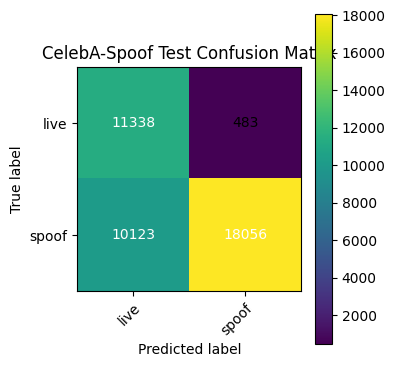


ROC AUC (from curve): 0.8991
Approx. EER: 19.12% at threshold ≈ 0.0326


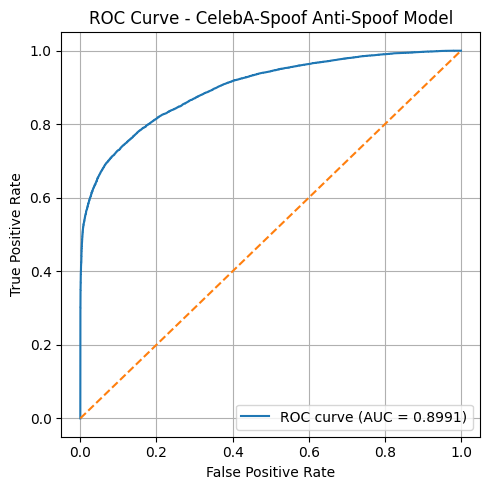

In [12]:
# Cell C: Detailed evaluation on test set

def collect_binary_preds(model, ds):
    """
    Collect y_true (0/1) and prediction probs (sigmoid output).
    """
    y_true = []
    y_prob = []

    for batch_x, batch_y in ds:
        y_true.extend(batch_y.numpy())
        prob = model.predict(batch_x, verbose=0).ravel()
        y_prob.extend(prob)

    y_true = np.array(y_true).astype(np.int32)
    y_prob = np.array(y_prob)
    return y_true, y_prob


def compute_eer(y_true, y_prob):
    """
    Approximate Equal Error Rate (EER) from ROC curve.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    fnr = 1.0 - tpr
    # EER where |FNR - FPR| is minimal
    abs_diff = np.abs(fnr - fpr)
    idx = np.argmin(abs_diff)
    eer = (fnr[idx] + fpr[idx]) / 2.0
    eer_threshold = thresholds[idx]
    roc_auc_val = auc(fpr, tpr)
    return eer, eer_threshold, fpr, tpr, roc_auc_val


# ===== Collect predictions on test set =====
y_true_test, y_prob_test = collect_binary_preds(anti_model, test_eval_ds)
y_pred_test = (y_prob_test >= 0.5).astype(np.int32)  # default threshold 0.5

# Classification report
print("=== Classification report (threshold = 0.5) ===")
print(classification_report(
    y_true_test,
    y_pred_test,
    target_names=["live", "spoof"],
    digits=4
))

# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
print("Confusion matrix:\n", cm)

def plot_confusion_matrix(cm, labels, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        ylabel="True label",
        xlabel="Predicted label",
        title=title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, ["live", "spoof"], "CelebA-Spoof Test Confusion Matrix")

# ROC curve + AUC + EER
eer, eer_thr, fpr, tpr, roc_auc_val = compute_eer(y_true_test, y_prob_test)
print(f"\nROC AUC (from curve): {roc_auc_val:.4f}")
print(f"Approx. EER: {eer*100:.2f}% at threshold ≈ {eer_thr:.4f}")

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_val:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CelebA-Spoof Anti-Spoof Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
